## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [2]:
pip install odc-geo --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [4]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup
import odc.geo.xr

from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import mostcommon_crs
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag
from coastlines.raster import model_tides

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36887 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:46335 Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36887/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


## Setup

In [5]:
dc = datacube.Datacube(app='Intertidal_elevation')

In [6]:
# aoi = 'Wollogorang'
# aoi = 'McCarthur River'
aoi = 'Greenbank'
# aoi = 'Seven Emu'

time_range = ('2017', '2021')
resolution = 10

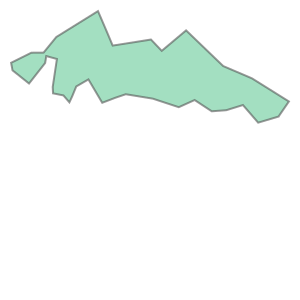

In [7]:
# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

In [51]:
from datacube.virtual import catalog_from_file

# Load in virtual product catalogue and select MNDWI product
catalog = catalog_from_file('configs/dea_virtual_product_landsat_s2.yaml')

In [52]:
# Create the 'query' dictionary object
query_params = {
    'geopolygon': geom,
    'time': time_range,
'dask_chunks': {'x': 2048, 'y': 2048}, 
'resolution': (-10, 10),
'output_crs': 'epsg:32753'}

In [53]:
product = catalog['s2_nbart']
product.load(dc, **query_params)

<xarray.Dataset>
Dimensions:      (time: 297, y: 3308, x: 8537)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-26T01:07:20.460000 ... 2021-12...
  * y            (y) float64 8.254e+06 8.254e+06 ... 8.221e+06 8.221e+06
  * x            (x) float64 6.581e+05 6.581e+05 ... 7.434e+05 7.435e+05
    spatial_ref  int32 32753
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    cloud_mask   (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    contiguity   (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [54]:
product = catalog['s2_nbart_ndwi']
product.load(dc, **query_params)

<xarray.Dataset>
Dimensions:      (time: 297, y: 3308, x: 8537)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-26T01:07:20.460000 ... 2021-12...
  * y            (y) float64 8.254e+06 8.254e+06 ... 8.221e+06 8.221e+06
  * x            (x) float64 6.581e+05 6.581e+05 ... 7.434e+05 7.435e+05
    spatial_ref  int32 32753
Data variables:
    cloud_mask   (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    contiguity   (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref